# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [29]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
raw_dataset = datasets.Imagenette(
    root='./data', 
    size='160px',
    download=False, 
)

In [31]:
raw_dataset

Dataset Imagenette
    Number of datapoints: 9469
    Root location: ./data

In [32]:
print(f"Clases del dataset: {raw_dataset.classes}")
print(f"Número de clases: {len(raw_dataset.classes)}")
print(f"Número de imágenes en el conjunto de entrenamiento: {len(raw_dataset)}")

Clases del dataset: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Número de clases: 10
Número de imágenes en el conjunto de entrenamiento: 9469


Image 0 - Label: 0
Image 1 - Label: 0
Image 2 - Label: 0
Image 3 - Label: 0
Image 4 - Label: 0
Image 5 - Label: 0


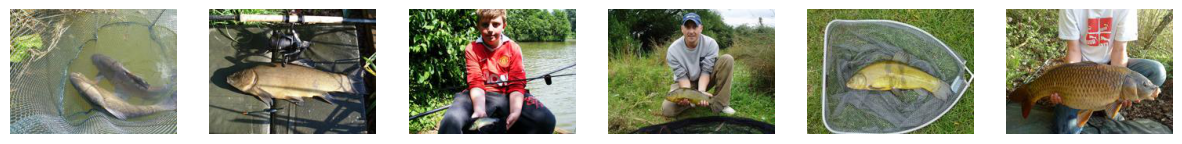

In [33]:
_, ejes = plt.subplots(1, 6, figsize=(15, 5)) 

for i in range(6):
    image, label = raw_dataset[i]
    print(f"Image {i} - Label: {label}")
    plt.imshow(image)

    ax = ejes[i]
    ax.imshow(image)
    ax.axis('off')
    

In [34]:
labels = [label for _, label in raw_dataset]
label_counts = Counter(labels)
label_counts = list(label_counts.items())
df = pd.DataFrame(label_counts, columns=["label_id", "count"])

df


,label_id,count
0,0,963
1,1,955
2,2,993
3,3,858
4,4,941
5,5,956
6,6,961
7,7,931
8,8,951
9,9,960


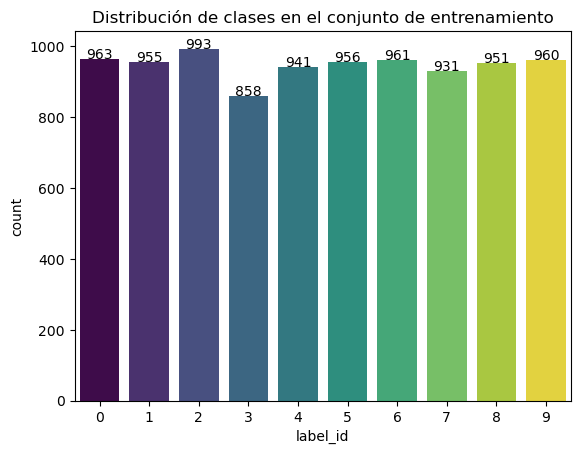

In [35]:
sns.barplot(data=df, x="label_id", y="count", hue="label_id",palette="viridis", legend=False)
plt.title("Distribución de clases en el conjunto de entrenamiento")

for i, row in df.iterrows():
    plt.text(i, row['count'] + 1, str(row['count']), ha='center')

### *Dataset Transformado*

In [36]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root='./data', 
    split='train', 
    size='160px',
    download=False, 
    transform=transform
)

val_dataset = datasets.Imagenette(
    root='./data', 
    split='val', 
    size='160px',
    download=False, 
    transform=transform
)

Image 0 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 1 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 2 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 3 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 4 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 5 - Label: 0 - Shape: torch.Size([3, 128, 128])


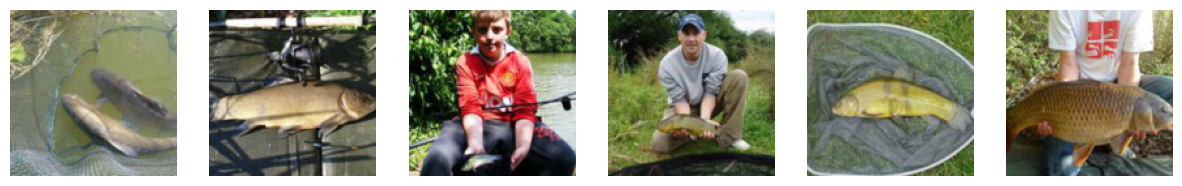

In [37]:
_, ejes = plt.subplots(1, 6, figsize=(15, 5))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i in range(6):
    image, label = train_data[i]
    print(f"Image {i} - Label: {label} - Shape: {image.shape}")
    image = image.permute(1, 2, 0).numpy() # C,H,W -> H,W,C
    image = std * image + mean # reverse normalization
    image = np.clip(image, 0, 1)
    
    ejes[i].imshow(image)
    ejes[i].axis("off")

In [38]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [39]:
class CNNPrueba(nn.Module):
    def __init__(self, num_classes):
        super(CNNPrueba, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*32*32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {device}")

num_classes = len(train_data.classes)
model = CNNPrueba(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Usando dispositivo: cpu


In [41]:
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


  3%|▎         | 1/30 [00:16<07:52, 16.28s/it]

Epoch 1/30, Loss: 1.7685


  7%|▋         | 2/30 [00:32<07:35, 16.26s/it]

Epoch 2/30, Loss: 1.3468


 10%|█         | 3/30 [00:49<07:23, 16.42s/it]

Epoch 3/30, Loss: 1.1413


 13%|█▎        | 4/30 [01:05<07:05, 16.36s/it]

Epoch 4/30, Loss: 0.9659


 17%|█▋        | 5/30 [01:21<06:49, 16.36s/it]

Epoch 5/30, Loss: 0.8365


 20%|██        | 6/30 [01:38<06:36, 16.54s/it]

Epoch 6/30, Loss: 0.7340


 23%|██▎       | 7/30 [01:55<06:21, 16.60s/it]

Epoch 7/30, Loss: 0.6235


 27%|██▋       | 8/30 [02:12<06:07, 16.70s/it]

Epoch 8/30, Loss: 0.5353


 30%|███       | 9/30 [02:28<05:50, 16.69s/it]

Epoch 9/30, Loss: 0.4473


 33%|███▎      | 10/30 [02:45<05:34, 16.70s/it]

Epoch 10/30, Loss: 0.3806


 37%|███▋      | 11/30 [03:02<05:17, 16.71s/it]

Epoch 11/30, Loss: 0.3079


 40%|████      | 12/30 [03:19<05:02, 16.79s/it]

Epoch 12/30, Loss: 0.2450


 43%|████▎     | 13/30 [03:36<04:45, 16.79s/it]

Epoch 13/30, Loss: 0.2188


 47%|████▋     | 14/30 [03:53<04:28, 16.81s/it]

Epoch 14/30, Loss: 0.1639


 50%|█████     | 15/30 [04:09<04:12, 16.82s/it]

Epoch 15/30, Loss: 0.1530


 53%|█████▎    | 16/30 [04:26<03:55, 16.84s/it]

Epoch 16/30, Loss: 0.1090


 57%|█████▋    | 17/30 [04:43<03:37, 16.72s/it]

Epoch 17/30, Loss: 0.0925


 60%|██████    | 18/30 [04:58<03:17, 16.44s/it]

Epoch 18/30, Loss: 0.0745


 63%|██████▎   | 19/30 [05:14<02:58, 16.25s/it]

Epoch 19/30, Loss: 0.0564


 67%|██████▋   | 20/30 [05:30<02:42, 16.21s/it]

Epoch 20/30, Loss: 0.0530


 70%|███████   | 21/30 [05:46<02:25, 16.14s/it]

Epoch 21/30, Loss: 0.0577


 73%|███████▎  | 22/30 [06:02<02:08, 16.09s/it]

Epoch 22/30, Loss: 0.0611


 77%|███████▋  | 23/30 [06:18<01:52, 16.06s/it]

Epoch 23/30, Loss: 0.0452


 80%|████████  | 24/30 [06:34<01:36, 16.06s/it]

Epoch 24/30, Loss: 0.0467


 83%|████████▎ | 25/30 [06:50<01:20, 16.02s/it]

Epoch 25/30, Loss: 0.0637


 87%|████████▋ | 26/30 [07:06<01:04, 16.01s/it]

Epoch 26/30, Loss: 0.0838


 90%|█████████ | 27/30 [07:22<00:48, 16.01s/it]

Epoch 27/30, Loss: 0.0602


 93%|█████████▎| 28/30 [07:38<00:32, 16.01s/it]

Epoch 28/30, Loss: 0.0454


 97%|█████████▋| 29/30 [07:54<00:16, 16.02s/it]

Epoch 29/30, Loss: 0.0353


100%|██████████| 30/30 [08:10<00:00, 16.37s/it]

Epoch 30/30, Loss: 0.0524


In [42]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.5875
Validation F1 Score: 0.5849


In [ ]:
class CNN_3L(nn.Module):
    def __init__(self, num_classes):
        super(CNN_3L, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = len(train_data.classes)
model_2 = CNN_3L(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=1e-3)

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model_2.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model_2(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:25<12:30, 25.88s/it]

Epoch 1/30, Loss: 1.6128


  7%|▋         | 2/30 [00:52<12:20, 26.43s/it]

Epoch 2/30, Loss: 1.1591


 10%|█         | 3/30 [01:19<11:59, 26.66s/it]

Epoch 3/30, Loss: 0.9639


 13%|█▎        | 4/30 [01:46<11:36, 26.79s/it]

Epoch 4/30, Loss: 0.8222


 17%|█▋        | 5/30 [02:14<11:21, 27.28s/it]

Epoch 5/30, Loss: 0.7020


 20%|██        | 6/30 [02:43<11:04, 27.68s/it]

Epoch 6/30, Loss: 0.5819


 23%|██▎       | 7/30 [03:11<10:43, 28.00s/it]

Epoch 7/30, Loss: 0.4713


 27%|██▋       | 8/30 [03:40<10:18, 28.11s/it]

Epoch 8/30, Loss: 0.3628


 30%|███       | 9/30 [04:08<09:53, 28.26s/it]

Epoch 9/30, Loss: 0.2805


 33%|███▎      | 10/30 [04:37<09:25, 28.29s/it]

Epoch 10/30, Loss: 0.1991


 37%|███▋      | 11/30 [05:06<09:00, 28.47s/it]

Epoch 11/30, Loss: 0.1643


 40%|████      | 12/30 [05:35<08:38, 28.80s/it]

Epoch 12/30, Loss: 0.1314


 43%|████▎     | 13/30 [06:04<08:08, 28.75s/it]

Epoch 13/30, Loss: 0.0932


 47%|████▋     | 14/30 [06:32<07:37, 28.60s/it]

Epoch 14/30, Loss: 0.0714


 50%|█████     | 15/30 [07:00<07:07, 28.51s/it]

Epoch 15/30, Loss: 0.0737


 53%|█████▎    | 16/30 [07:29<06:38, 28.49s/it]

Epoch 16/30, Loss: 0.0564


 57%|█████▋    | 17/30 [07:57<06:10, 28.48s/it]

Epoch 17/30, Loss: 0.0468


 60%|██████    | 18/30 [08:25<05:40, 28.41s/it]

Epoch 18/30, Loss: 0.0529


 63%|██████▎   | 19/30 [08:54<05:12, 28.40s/it]

Epoch 19/30, Loss: 0.0890


 67%|██████▋   | 20/30 [09:22<04:43, 28.39s/it]

Epoch 20/30, Loss: 0.0475


 70%|███████   | 21/30 [09:51<04:15, 28.41s/it]

Epoch 21/30, Loss: 0.0477


 73%|███████▎  | 22/30 [10:19<03:47, 28.38s/it]

Epoch 22/30, Loss: 0.0321


 77%|███████▋  | 23/30 [10:47<03:18, 28.39s/it]

Epoch 23/30, Loss: 0.0408


 80%|████████  | 24/30 [11:16<02:50, 28.45s/it]

Epoch 24/30, Loss: 0.0237


 83%|████████▎ | 25/30 [11:45<02:23, 28.61s/it]

Epoch 25/30, Loss: 0.0461


 87%|████████▋ | 26/30 [12:14<01:54, 28.59s/it]

Epoch 26/30, Loss: 0.0379


 90%|█████████ | 27/30 [12:42<01:25, 28.58s/it]

Epoch 27/30, Loss: 0.0361


 93%|█████████▎| 28/30 [13:11<00:57, 28.62s/it]

Epoch 28/30, Loss: 0.0476


 97%|█████████▋| 29/30 [13:39<00:28, 28.56s/it]

Epoch 29/30, Loss: 0.0614


100%|██████████| 30/30 [14:08<00:00, 28.27s/it]

Epoch 30/30, Loss: 0.0467


In [50]:
model_2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.6690
Validation F1 Score: 0.6672


In [ ]:
class CNN_4L(nn.Module):
    def __init__(self, num_classes):
        super(CNN_4L, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = len(train_data.classes)
model_3 = CNN_4L(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_3.parameters(), lr=1e-3)

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model_3.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model_3(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
model_3.eval()
all_preds_3 = []
all_labels_3 = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_3.extend(predicted.cpu().numpy())
        all_labels_3.extend(labels.cpu().numpy())

acc_3 = accuracy_score(all_labels_3, all_preds_3)
f1_3 = f1_score(all_labels_3, all_preds_3, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")